## Image Analysis Pipeline 

##### Import necessary modules and generate a random pastel colormap to use later

In [1]:
import numpy as np

import matplotlib.pyplot as plt
# Set matplotlib backend
%matplotlib inline 

import scipy.ndimage as ndi

# Function found by Guille from stackoverflow to generate random pastel colormaps.
# It will generate as many colors as cells we detect in the segmentation.
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [56]:
# importing the image file
from os.path import join

filename = '20201211 Optoshroom repeated stim 3 att3.tif'
originalname = filename[:-4] #Taking filename without .tif to use it when saving data
dirpath = r'C:\Users\ara\Documents\Python Scripts\Repeated Stimulation Analysis\PreProcessedfiles\Exp3'
filepath = join(dirpath, filename)

print(filepath)

from skimage.io import imread
img = imread(filepath)

img.shape
# img.shape axes/dimensions: t,z,y,x


C:\Users\ara\Documents\Python Scripts\Repeated Stimulation Analysis\PreProcessedfiles\Exp3\20201211 Optoshroom repeated stim 3 att3.tif


(80, 16, 512, 512)

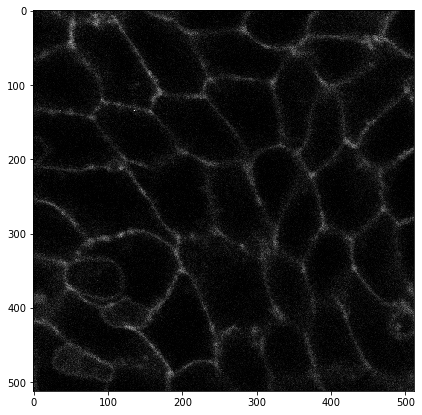

In [263]:
# To select a specific stack/plane
# For a max projection we use the above to define the planes and then use np.max(imgfin[:,:,:],0)

stackbeg = 10 #stackstart and stackend variables - to use for the max projection (begining and end)
stackend = 11
proj = np.max(img[:,stackbeg:stackend,:,:], 1) #proj variable - select stack to do max projection
## if we only want one slice
slicepicked = 3
#proj = img[:,slicepicked,:,:]
imgfin = proj[0,:,:] #imgfin variable - the projection of the image that is used throughout the analysis 
#APICAL OR BASAL
aorb = 'basal'

plt.figure(figsize = (7, 7))
plt.imshow(imgfin, interpolation = 'none', cmap = 'gray')
plt.show()

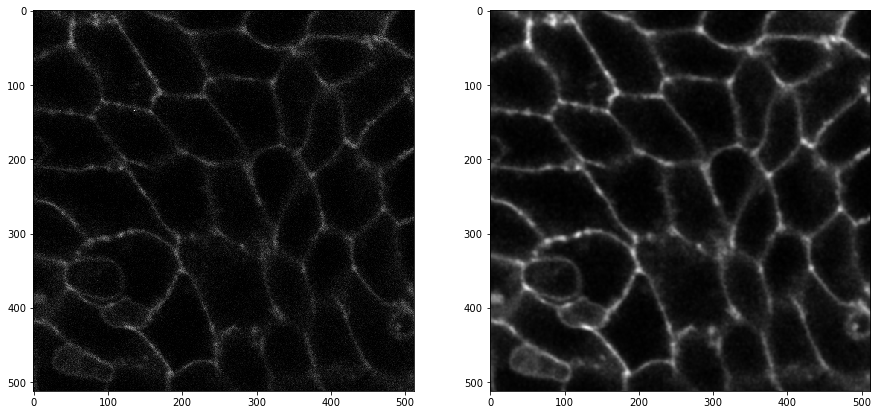

In [265]:
# Apply a smoothing filter. In this case Gaussian filter. Sigma factor is defined in the parenthesis
# You can check the results and change the sigma factor accordingly

sigma = 1.5 #sigma variable - to be used for the gaussian filter on the image
imggaussian = ndi.filters.gaussian_filter(imgfin, sigma) #imggaussian variable - the image with gaussian filter applied 

# We can use subplot to display the original and smoothed image side by side to compare 
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(imgfin, interpolation='none', cmap='gray')
ax[1].imshow(imggaussian, interpolation='none', cmap='gray')
plt.show()

C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3987), equivalent to an approximate bitdepth of 12.0.
  out_dtype)


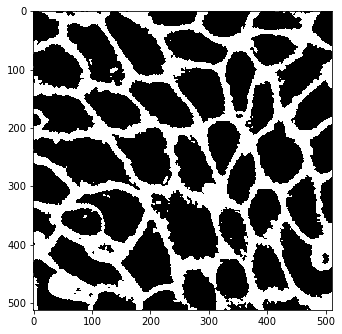

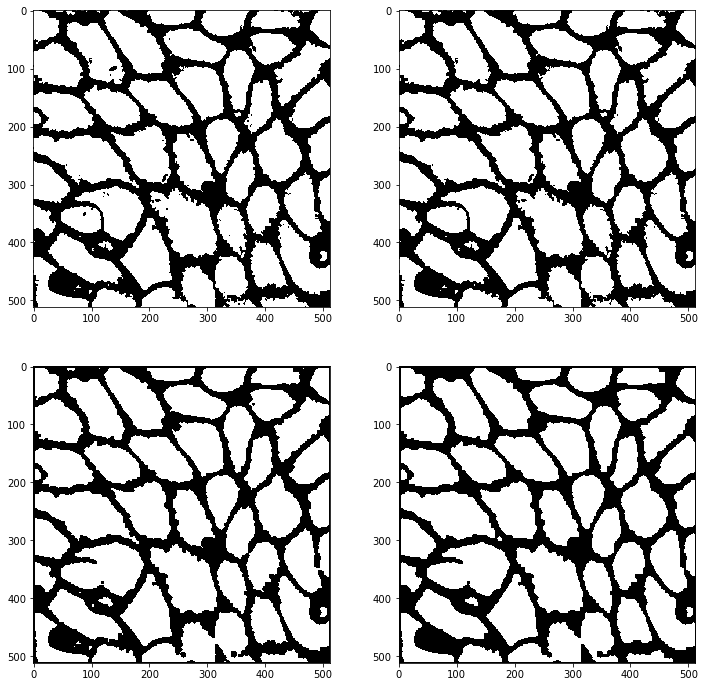

In [266]:
# Adaptive Thresholding by defining a kernel disk of certain size (Jonas' Tutorial)
# You can change the size of the kernel disk by altering i variable. It is advisable to try out a few different values
i = 150
struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2 #struct variable - the structural element(SE) we define to do adaptive threshold

from skimage.filters.rank import mean as skimagemean

# Generating a background image
bg = skimagemean(imgfin, struct) #bg variable - background we use to do the adaptive thresholding
adaptthres = imggaussian > bg #adaptthres variable - the adaptive threshold binary image that we make 

# We invert the mask of the adapted threshold to show the cells and use it to improve the thresholding results with morphological filters
inverted = np.logical_not(adaptthres) #inverted variable - we store the inverted binary image of the adaptthres to show the cells 

# We define another structural element(Jonas' Tutorial) to use for removing speckles and filling holes in our image
# Again, it is important to check different values for the kernel disk size to find the optimal for your data everytime
i = 6
struct2 = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2 #struct2 variable - the SE we define to apply morphological filters to improve thresholding


filled = ndi.binary_fill_holes(inverted, struct2) #filled variable - we store the binary image with fill_holes morphological filter applied
openclose = ndi.binary_closing(filled, struct2) #openclose variable - we store the binary image with closing morphological filter applied
opened = ndi.binary_opening(openclose, struct2) #opened variable - we store the binary image with morphological filter applied

# We visualize the results by showing the adapted threshold mask before the morphological filter 
# and by sublotting the original inverted mask and after the morphological filters' application 
plt.figure(figsize = (5.5, 5.5))
plt.imshow(adaptthres, interpolation='none', cmap='gray')
plt.show()

plt.figure(figsize = (12, 12))
plt.subplot(2, 2, 1)
plt.imshow(inverted, interpolation = 'none', cmap = 'gray')
plt.subplot(2, 2, 2) 
plt.imshow(filled, interpolation = 'none', cmap = 'gray')
plt.subplot(2, 2, 3)
plt.imshow(openclose, interpolation = 'none', cmap = 'gray')
plt.subplot(2, 2, 4)
plt.imshow(opened, interpolation = 'none', cmap = 'gray')
plt.show()

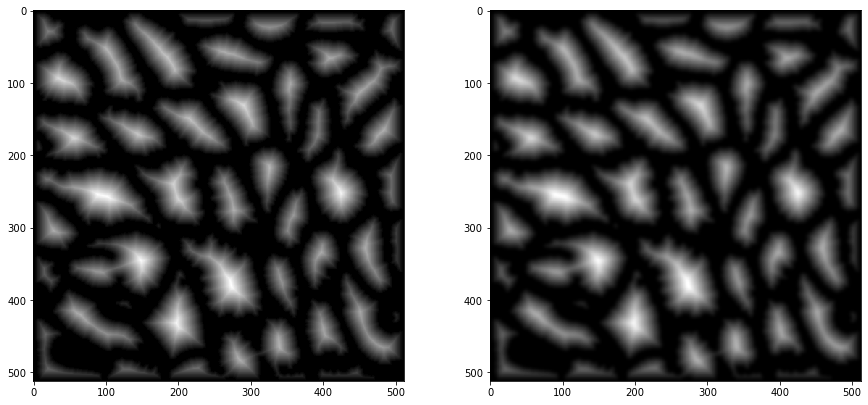

In [267]:
# We start the process of watershed segmentation
# Here we do distance transform to find the seeds for the watershed algorithm

disttrans = ndi.distance_transform_edt(opened) #disttrans variable - we store the distance transform to the binary image 

# We also use a gaussian filter on the distance transform result. 
# Again the sigma can be altered. 

sigma2 = 2 #sigma2 variable - sigma value for gaussian filter on the disttrans image 
distgaussian = ndi.filters.gaussian_filter(disttrans, sigma2) #distgaussian variable - we store the result of performing gaussian smooth on the disttrans image

plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.imshow(disttrans, interpolation = 'none', cmap = 'gray')
plt.subplot(2, 2, 2) 
plt.imshow(distgaussian, interpolation = 'none', cmap = 'gray')
plt.show()

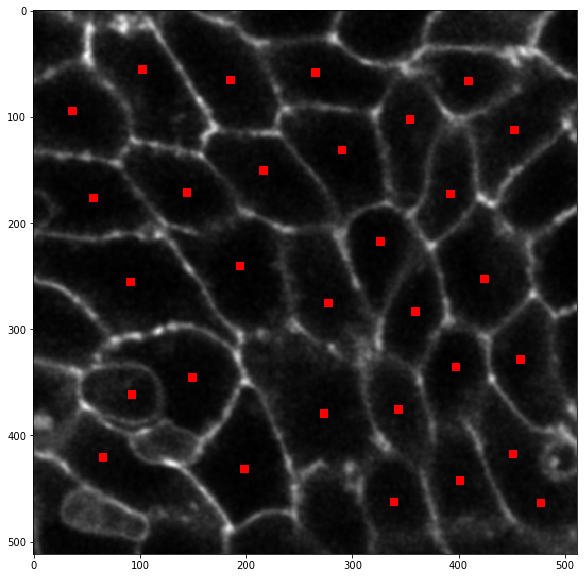

In [268]:
# The seeds will be on the local maxima points. To find the local maxima points we use peak_local_max. 
# min_distance is the variable that you have to explore to find the optimal
# by increasing its value there will be more object merges and by decreasing it there will be more object splits
from skimage.feature import peak_local_max

mindist = 34 #mindist variable - we save the minimum distance to be used for watershed 
peaks = peak_local_max(distgaussian, indices = False, min_distance = mindist) #peaks variable - stores the seeds for the watershed

###Update on 17th June 2020
# We dilate the peaks - seeds for better visualization
# Then for connected component labelling we use peaks variable and not the dilated 
peaksdil = ndi.filters.maximum_filter(peaks, size = 8)
mask = np.ma.masked_where(peaksdil < 1, peaksdil) #mask variable - we store the masked array on the condition peaks<1


# We visualize the result by showing the original smooth image with the local maxima points mask as an overlay
plt.figure(figsize = (10, 10))
plt.imshow(imggaussian, interpolation = 'none', cmap = 'gray')
plt.imshow(mask, interpolation = 'none', cmap = 'prism')
plt.show()

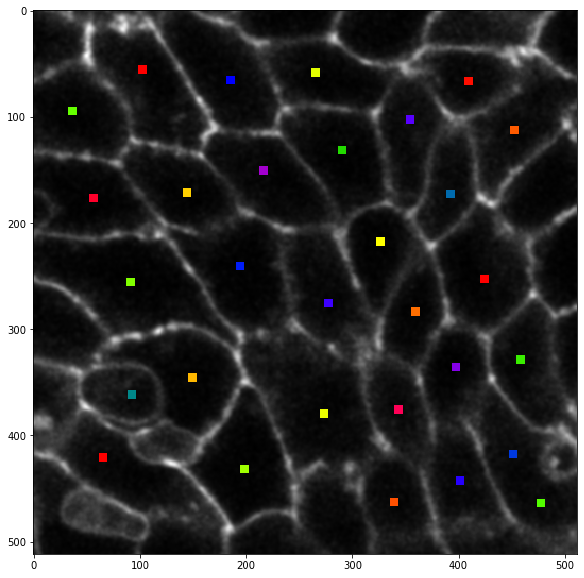

In [269]:
# Now we do connected component labeling. Here we label the seeds on the local maxima points. 
# We use numberpeaks to save the number of seeds, hence the number of detected cells to generate the random colormap afterwards

labelledpeaks, numberpeaks = ndi.label(peaks) #labelledpeaks variable - we store the labelled seeds 
#numberpeaks variable - we use this to save the number of detected cells

# We visualize the results as previously, with showing the labeled seeds as an overlay to the original smooth image
###Update on 17th June 2020
# We dilate the peaks - seeds for better visualization
# Then for watershed we use labelledpeaks variable and not the dilated 
labelledpeaksdil = ndi.filters.maximum_filter(labelledpeaks, size = 8)
masklabel = np.ma.masked_where(labelledpeaksdil < 1, labelledpeaksdil) #masklabel - we store the masked array on the condition labelledpeaks<1

plt.figure(figsize=(10, 10))
plt.imshow(imggaussian, interpolation = 'none', cmap = 'gray')
plt.imshow(masklabel, interpolation = 'none', cmap = 'prism')
plt.show()

30
Number of labels: 35


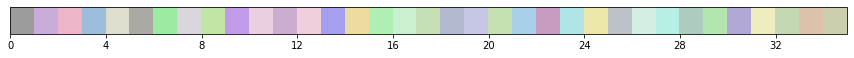

In [270]:
# We check how many cells have been detected by printing the number of cells. Number 0 is background
print(numberpeaks) 

# We generate a random pastel color map with the function that was defined in the begining
# The colormap will have as many colors as the numberpeaks plus 5
# This colormap will be used to visualize the segmentation result
randomcol = rand_cmap(numberpeaks + 5, type = 'soft', first_color_black = False) #randomcol variable - the generated colormap

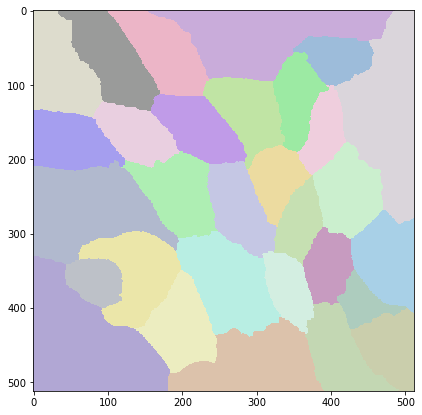

In [271]:
# We use watershed function to perform the watershed segmentation
from skimage.morphology import watershed

watersegm = watershed(imggaussian, labelledpeaks) #watersegm variable - we store the result of the segmentation

plt.figure(figsize = (7, 7))
plt.imshow(watersegm, interpolation = 'none', cmap = randomcol)
#plt.savefig('figurename.png', bbox_inches='tight')
plt.show()

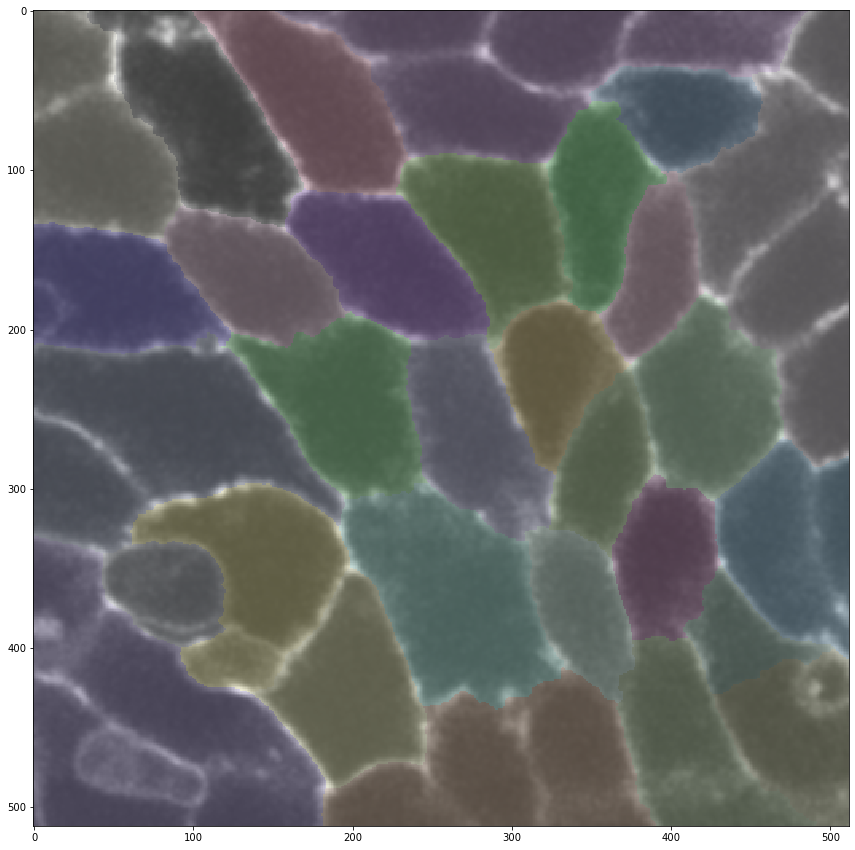

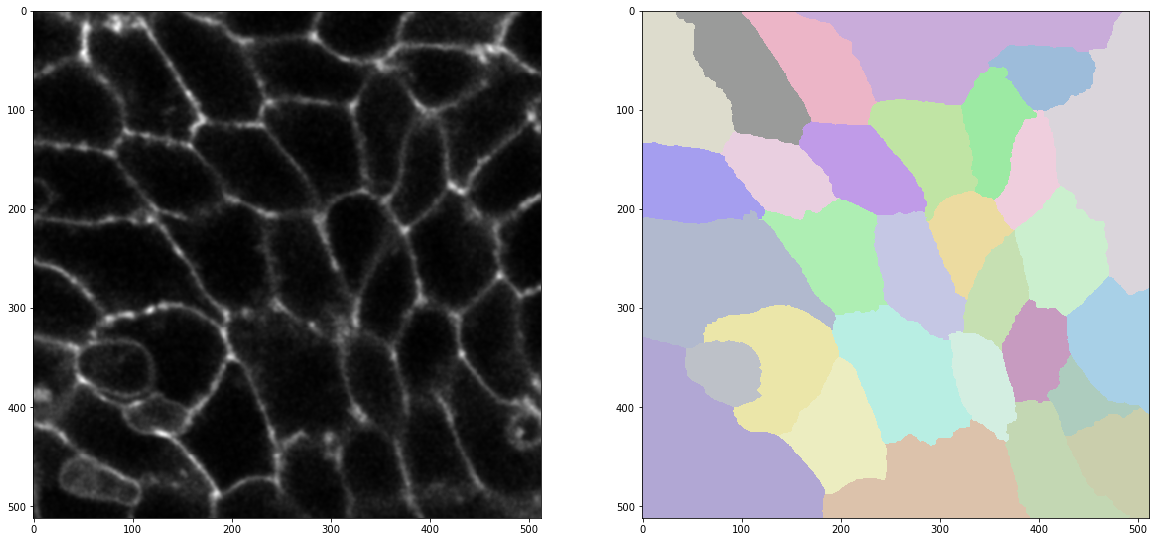

In [272]:
# We visualize the result to compare with the original image:
# overlay of the segmentation on the original image
# subplot of the original image and the segmentation image 

plt.figure(figsize=(15, 15))
plt.imshow(imggaussian, interpolation = 'none', cmap = 'gray')
plt.imshow(watersegm, interpolation = 'none', cmap = randomcol, alpha = 0.4)
#plt.savefig('figurename.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (20, 20))
plt.subplot(1, 2, 1)
plt.imshow(imggaussian, interpolation = 'none', cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(watersegm, interpolation = 'none', cmap = randomcol)
#plt.savefig('figurename.png', bbox_inches='tight')
plt.show()

## Cell tracking

We check every timepoint and track the cell by choosing the cell that shares the greatest percentage of surface with the cell we want to track (either the constricting/activated one or others)

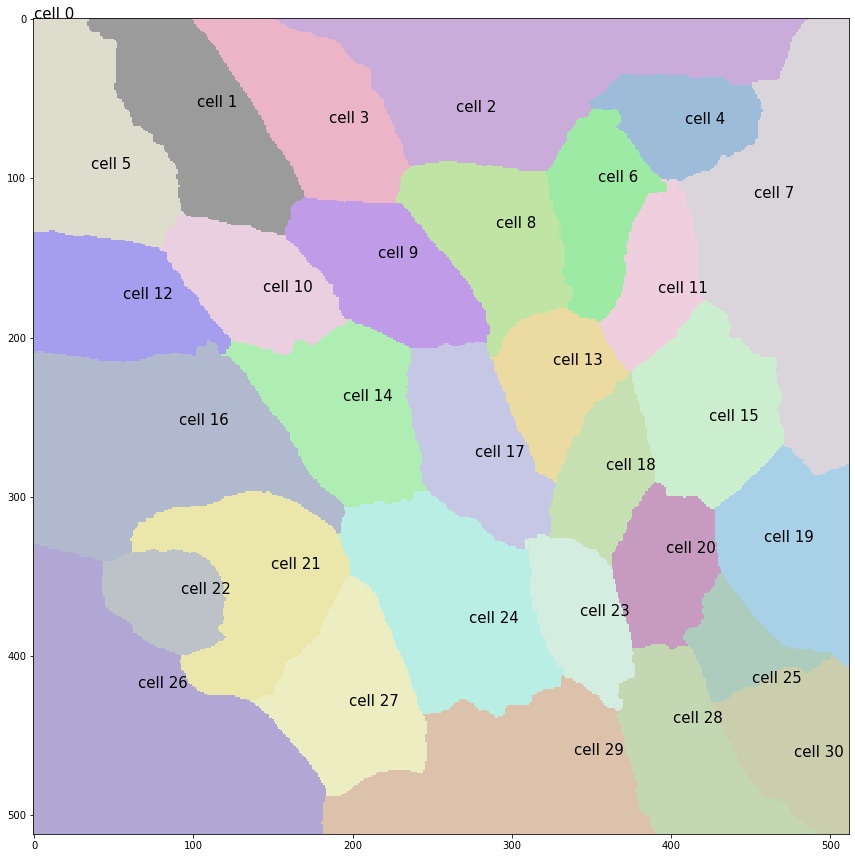

In [273]:
# We make a copy of the original watersegm file that contains the watershed segmentation result to avoid altering it by making mistakes
segmentcopy = np.copy(watersegm) #segmentcopy variable - copy of the watersegm file

# Then we iterate through the cell IDs (numberpeaks) to make an overlay of the cell ID numbers on the segmentation image
# The text with the cell ID will be the location of the seed for each cell
plt.figure(figsize = (15, 15))
plt.imshow(segmentcopy, interpolation = 'none', cmap = randomcol)
for i in range(numberpeaks + 1):
    
    selectedpeak = labelledpeaks == i
    peaklocation = np.where(labelledpeaks == i)
    peaklocations = np.column_stack((peaklocation[0], peaklocation[1])) #peaklocations variable - where the text of the cellID is showed
    plt.text(peaklocations[0,1], peaklocations[0,0], "cell " + str(i), fontsize = 15) 
plt.show()

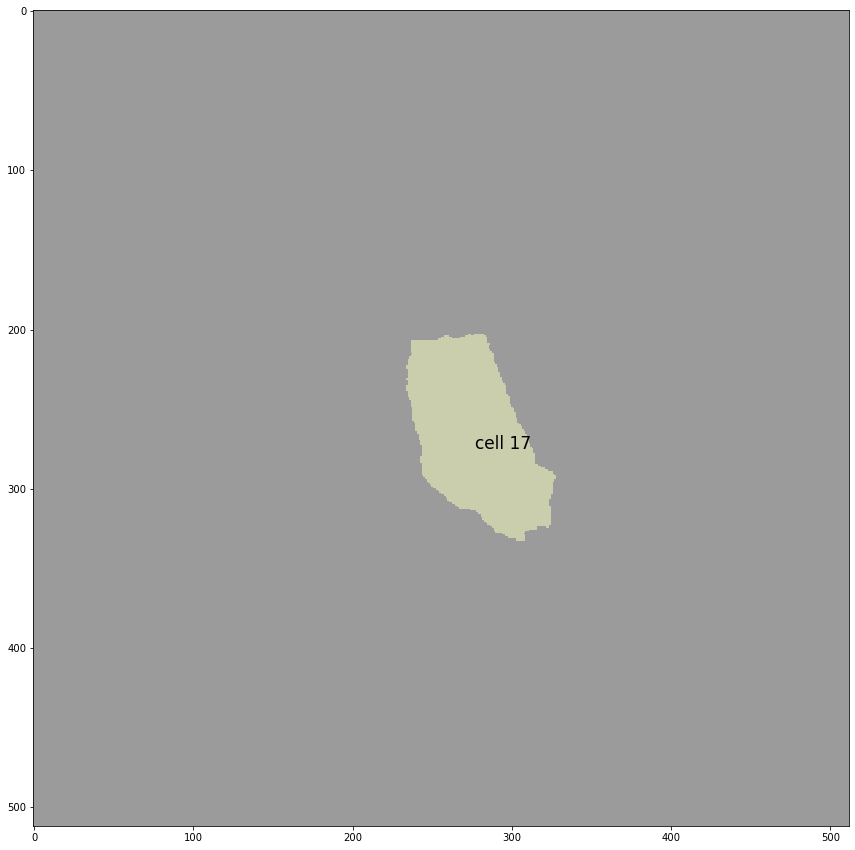

In [274]:
#Cell number 0 is background, we can choose the cell that interests us by choosing its number ID on this timepoint. i = cell ID 
cell = 17
currentcell = segmentcopy == cell #find the cell of interest in the segmentcopy file and assign it to current cell variable 

# As a sanity check we show only the cell we chose 
plt.figure(figsize=(15, 15))
plt.imshow(currentcell, interpolation = 'none', cmap = randomcol)
selectedpeak = labelledpeaks == cell
peaklocation = np.where(labelledpeaks == cell)
peaklocations =np.column_stack((peaklocation[0], peaklocation[1]))
plt.text(peaklocations[0,1], peaklocations[0,0], "cell " + str(cell), fontsize=17)
plt.show()

0
1


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3108), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


2


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (2717), equivalent to an approximate bitdepth of 11.4.
  out_dtype)


3


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3153), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


4


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3331), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


5


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3081), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


6


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3102), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


7


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3897), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


8


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (2908), equivalent to an approximate bitdepth of 11.5.
  out_dtype)


9


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3237), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


10


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3029), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


11


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3414), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


12


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3355), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


13


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3394), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


14


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3189), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


15


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3280), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


16


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3245), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


17


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3558), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


18


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (4096), equivalent to an approximate bitdepth of 12.0.
  out_dtype)


19


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3118), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


20


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (2932), equivalent to an approximate bitdepth of 11.5.
  out_dtype)


21


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3191), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


22


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3258), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


23


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3004), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


24


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3305), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


25


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (2892), equivalent to an approximate bitdepth of 11.5.
  out_dtype)


26
27


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3266), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


28


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3154), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


29


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (2857), equivalent to an approximate bitdepth of 11.5.
  out_dtype)


30


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3155), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


31


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3788), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


32


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3256), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


33


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3168), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


34


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3871), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


35


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3242), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


36


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3185), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


37


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3804), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


38


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3235), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


39


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3516), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


40
41


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3841), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


42


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3592), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


43


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3165), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


44


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3631), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


45


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3248), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


46


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3779), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


47


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3238), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


48


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3001), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


49


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3275), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


50


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3338), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


51


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3388), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


52


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3480), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


53


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3396), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


54


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3674), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


55
56


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3349), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


57


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3319), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


58
59


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3078), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


60


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3076), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


61


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3417), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


62


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3285), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


63


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3252), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


64


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3527), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


65


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3690), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


66


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3374), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


67


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3754), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


68


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3052), equivalent to an approximate bitdepth of 11.6.
  out_dtype)


69


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3282), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


70
71


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3356), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


72


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3585), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


73


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3482), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


74


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3326), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


75


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3952), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


76


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3406), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


77


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (3528), equivalent to an approximate bitdepth of 11.8.
  out_dtype)


78


C:\Users\ara\Documents\Anaconda\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Bad rank filter performance is expected due to a large number of bins (2989), equivalent to an approximate bitdepth of 11.5.
  out_dtype)


79


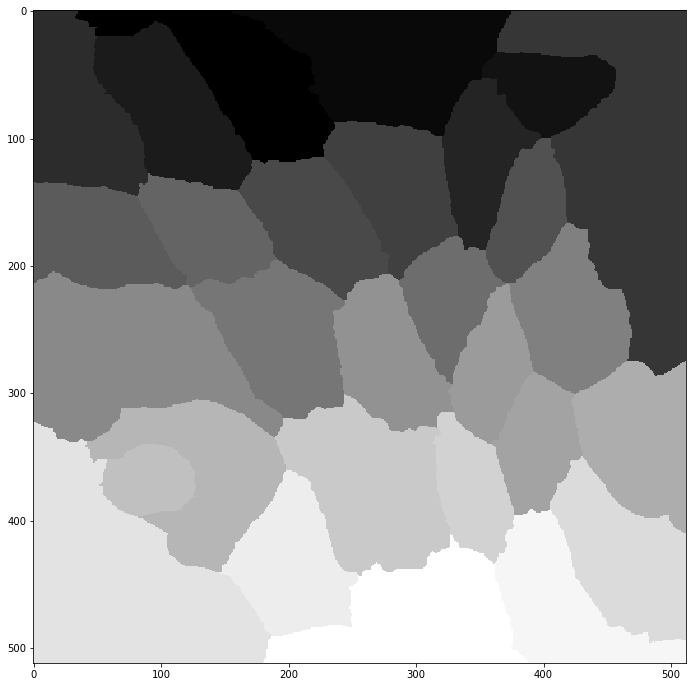

In [275]:
# To continue we need to do a segmentation of all timepoints. We follow the exact same process as before. 
# This is done automatically through the iteration for every timepoint.

time = img.shape[0]
listofplanes = [] #listofplanes variable - we store the segmentation of each plane 
listsegmented = [] #listsegmented variable - we store 
for i in range(time):
    print(i)
    imgfinr = proj[i,:,:]
    imggaussianr = ndi.filters.gaussian_filter(imgfinr, sigma) #Making gaussian blur
    bgr = skimagemean(imgfinr, struct)
    adaptthresr = imggaussianr > bgr #Making adapted threshold
    invertedr = np.logical_not(adaptthresr)
    filledr = ndi.binary_fill_holes(invertedr, struct2) #Morphological operations
    opencloser = ndi.binary_closing(filledr, struct2) 
    openedr = ndi.binary_opening(opencloser, struct2)
    disttrr = ndi.distance_transform_edt(openedr)
    distgaussianr = ndi.filters.gaussian_filter(disttrr, sigma2)
    peaksr = peak_local_max(distgaussianr, indices=False, min_distance=mindist)
    labelledpeaksr, featurepeaksr = ndi.label(peaksr)
    watersegmr = watershed(imggaussianr, labelledpeaksr) #Watershed segmentation
    listsegmented.append(openedr)
    listofplanes.append(watersegmr) #Storing all of them on a list

# We show one of the timepoints to see how this worked. 
# You can choose which one you want to check by changing the index in listofplanes
plt.figure(figsize=(12, 12))

plt.imshow(listofplanes[22], interpolation = 'none', cmap = 'gray')

7583


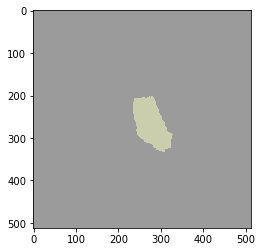

In [276]:
# Now that we can choose the cell that interests us we can do measurements for it in this timepoint
#cell = 8 # I already assigned this variable before

# We use the module measure and more specifically the function measure.regionprops. This measures a number of features for our cell. Our interest is in the area of the cell
# To measure area we can use segmentprops[index].area
# Area is measured in pixels^2 this way
from skimage import measure

segmentcell = segmentcopy == cell #segmentcell variable - segmentation of the cell of interest
segmentint = segmentcell.astype(int) #segmentint variable - changing datatype to integer
Props = measure.regionprops(segmentint) #Props variable - we store the measurements done for several features 
firstarea = Props[0].area #firstarea variable - we choose only surface measurement from the Props measured
print(firstarea)
plt.imshow(segmentcell, interpolation = 'none', cmap = randomcol)

In [277]:
#Cell tracking and surface area measurements 

#cell = 8 #(Cell was chosen before already! I guess this will be useful for a loop on all cells)
startingcell = segmentcopy == cell
startingcell=np.where(startingcell == cell, 1, startingcell)
startingcell.dtype
listofcells = []

for a in range(time): # for all timepoints
    print(a)
    currentplane = listofplanes[a]
    temporal = np.zeros([1,2],dtype = int)
    for i in np.unique(currentplane): # For each cell in the current plane
    # We create a mask that contains only the 'current' cell of the iteration
        currentcell = currentplane == i
    # Using the cell mask and the border mask from above, test if the cell has pixels touching the the cell on the previous timepoint or not.
        test1 = np.logical_and(currentcell, startingcell)
    # If a cell touches the previous cell, we add it to a list together with the area they share in common.
        if True in test1:
            testint = test1.astype(int)
            Props = measure.regionprops(testint)
            x = Props[0].area
            temporal = np.append(temporal, [[i,x]], axis=0)
        else:
            continue
    print(temporal) # Then we print all the cells that share some area with the cell that interests us
    maxim = np.amax(temporal, axis = (0,1))
    d = np.where(temporal == maxim) # We consider that the cell that has a bigger area shared is probably the same cell on the new timepoint
    row = int(d[0])
    realcell = temporal[row, 0]
    listofcells.append(realcell) # We store on a list the number that the cell of interest has received during labelling for each timepoint to find it in every timepoint 
    
    #Added by Guillermo 15th June 2020, the new starting cell, is the one we have picked in this plane!
    #Tracking plane after plane
    startingcell = currentplane == realcell
    startingcell=np.where(startingcell == realcell, 1, startingcell)
    startingcell.dtype

# We print the list we made above with the labeling
print(listofcells) 

0
[[   0    0]
 [  17 7583]]
1
[[   0    0]
 [   8   13]
 [   9    7]
 [  13   58]
 [  14   13]
 [  17 7250]
 [  18    7]
 [  23   15]
 [  24  220]]
2
[[   0    0]
 [   8    5]
 [   9  103]
 [  13   37]
 [  14   88]
 [  17 7187]
 [  23   15]
 [  24    2]]
3
[[   0    0]
 [   8    7]
 [   9  105]
 [  13   51]
 [  14    1]
 [  17 7238]
 [  18   39]
 [  23   75]
 [  24   23]]
4
[[   0    0]
 [   8    8]
 [   9   13]
 [  13   60]
 [  14   38]
 [  17 7275]
 [  18    3]
 [  23    2]
 [  24   38]]
5
[[   0    0]
 [   9   57]
 [  13   83]
 [  14    6]
 [  17 7289]
 [  18    8]
 [  23    2]
 [  24   70]]
6
[[   0    0]
 [   9   57]
 [  13   73]
 [  14  146]
 [  17 7128]
 [  18   49]
 [  23   92]
 [  24    2]]
7
[[   0    0]
 [   9    2]
 [  13  136]
 [  14    5]
 [  17 7032]
 [  18   14]
 [  23  184]
 [  24   71]]
8
[[   0    0]
 [   8    3]
 [   9   45]
 [  13  136]
 [  14   12]
 [  17 7069]
 [  18   32]
 [  23   24]
 [  24   75]]
9
[[   0    0]
 [   8   19]
 [   9   16]
 [  13   20]
 [  14  1

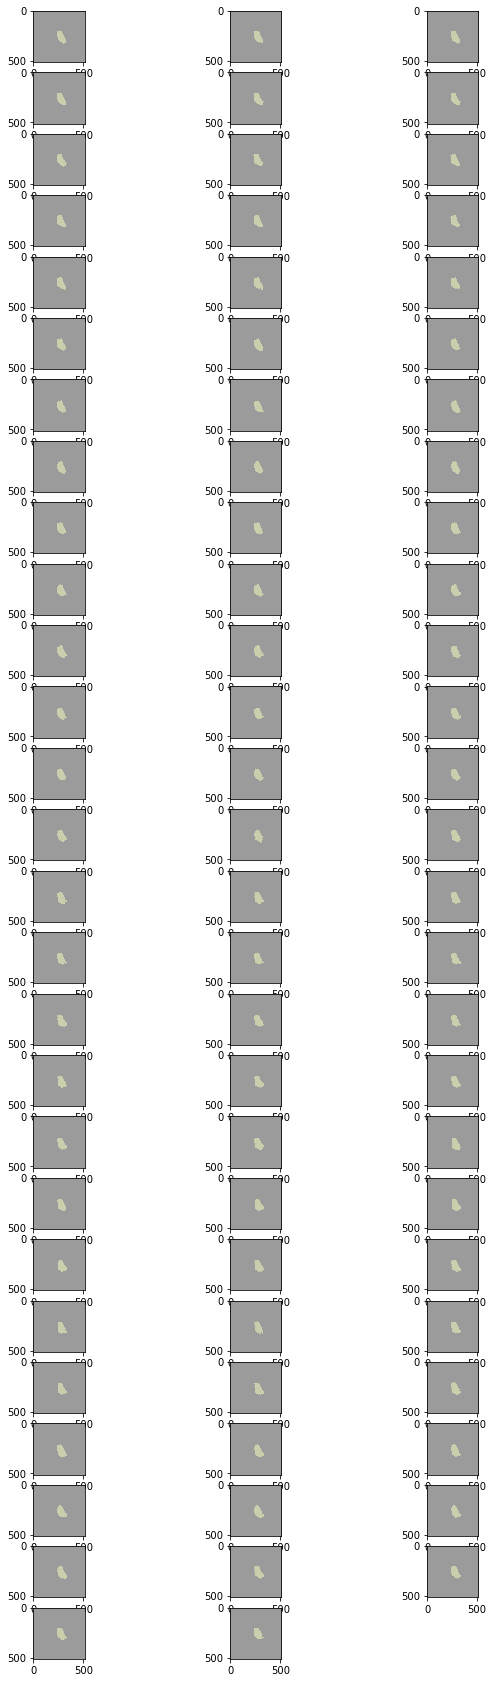

In [278]:
# To make sure we can track the cell in each timepoint correctly (and also to check the segmentation one more time!) we subplot the tracked cell alone in every timepoint

plt.figure(figsize = (10, 45))
for i in range(time):
    currentplane = listofplanes[i]
    a = listofcells[i]
    currentcell = currentplane == a
    plt.subplot(time//2, 3, i+1)
    plt.imshow(currentcell, interpolation = 'none', cmap = randomcol)
plt.show()

In [279]:
# If we like the above results we can move on to doing measurements! 
# We didn't use the first timepoint in the previous iteration and now we need to add it before iterating through timepoints
# For each timepoint we measure the area and we store it in a list 

temporal2 = np.array([[0,0]],dtype = int)

for i in range(time): 
    print(i)
    currentplane = listofplanes[i]
    a = listofcells[i]
    currentcell = currentplane == a
    currentint = currentcell.astype(int)
    Props=measure.regionprops(currentint)
    x = Props[0].area
    temporal2 = np.append(temporal2, [[i,x]], axis=0) #temporal2 variable - stores the area measurement for each timepoint for the cell of interest
    print(a)

temporal3 = temporal2[1:,:] #temporal3 variable - we remove the 0,0 we used to initialize the temporal2 array
print(temporal3)

0
17
1
17
2
17
3
17
4
17
5
17
6
17
7
17
8
17
9
17
10
17
11
17
12
17
13
17
14
17
15
17
16
17
17
18
18
18
19
17
20
17
21
17
22
17
23
18
24
17
25
17
26
17
27
18
28
18
29
18
30
16
31
18
32
18
33
17
34
18
35
17
36
17
37
17
38
18
39
19
40
18
41
18
42
19
43
19
44
19
45
19
46
19
47
19
48
19
49
19
50
18
51
18
52
18
53
18
54
18
55
19
56
19
57
18
58
18
59
18
60
18
61
18
62
18
63
18
64
18
65
18
66
18
67
18
68
18
69
18
70
18
71
18
72
17
73
18
74
17
75
17
76
17
77
17
78
17
79
17
[[   0 7583]
 [   1 7437]
 [   2 7539]
 [   3 7437]
 [   4 7515]
 [   5 7547]
 [   6 7444]
 [   7 7396]
 [   8 7357]
 [   9 7320]
 [  10 7422]
 [  11 7283]
 [  12 7387]
 [  13 7411]
 [  14 7254]
 [  15 7385]
 [  16 7531]
 [  17 7264]
 [  18 7181]
 [  19 7267]
 [  20 7594]
 [  21 7239]
 [  22 7391]
 [  23 7576]
 [  24 7432]
 [  25 7237]
 [  26 7570]
 [  27 7327]
 [  28 7479]
 [  29 7402]
 [  30 7525]
 [  31 7505]
 [  32 7369]
 [  33 7086]
 [  34 6972]
 [  35 7329]
 [  36 7019]
 [  37 7146]
 [  38 7269]
 [  39 7476]
 [  40 723

[[   0 7583]
 [   1 7437]
 [   2 7539]
 [   3 7437]
 [   4 7515]
 [   5 7547]
 [   6 7444]
 [   7 7396]
 [   8 7357]
 [   9 7320]
 [  10 7422]
 [  11 7283]
 [  12 7387]
 [  13 7411]
 [  14 7254]
 [  15 7385]
 [  16 7531]
 [  17 7264]
 [  18 7181]
 [  19 7267]
 [  20 7594]
 [  21 7239]
 [  22 7391]
 [  23 7576]
 [  24 7432]
 [  25 7237]
 [  26 7570]
 [  27 7327]
 [  28 7479]
 [  29 7402]
 [  30 7525]
 [  31 7505]
 [  32 7369]
 [  33 7086]
 [  34 6972]
 [  35 7329]
 [  36 7019]
 [  37 7146]
 [  38 7269]
 [  39 7476]
 [  40 7232]
 [  41 7625]
 [  42 7509]
 [  43 7433]
 [  44 7484]
 [  45 7211]
 [  46 6976]
 [  47 7449]
 [  48 8051]
 [  49 7488]
 [  50 7225]
 [  51 7387]
 [  52 7554]
 [  53 7361]
 [  54 7413]
 [  55 7664]
 [  56 7529]
 [  57 7474]
 [  58 7492]
 [  59 7629]
 [  60 7633]
 [  61 7626]
 [  62 7720]
 [  63 7441]
 [  64 7386]
 [  65 7519]
 [  66 7525]
 [  67 7858]
 [  68 7668]
 [  69 7942]
 [  70 7939]
 [  71 7545]
 [  72 7578]
 [  73 8051]
 [  74 7686]
 [  75 7806]
 [  76 7839]

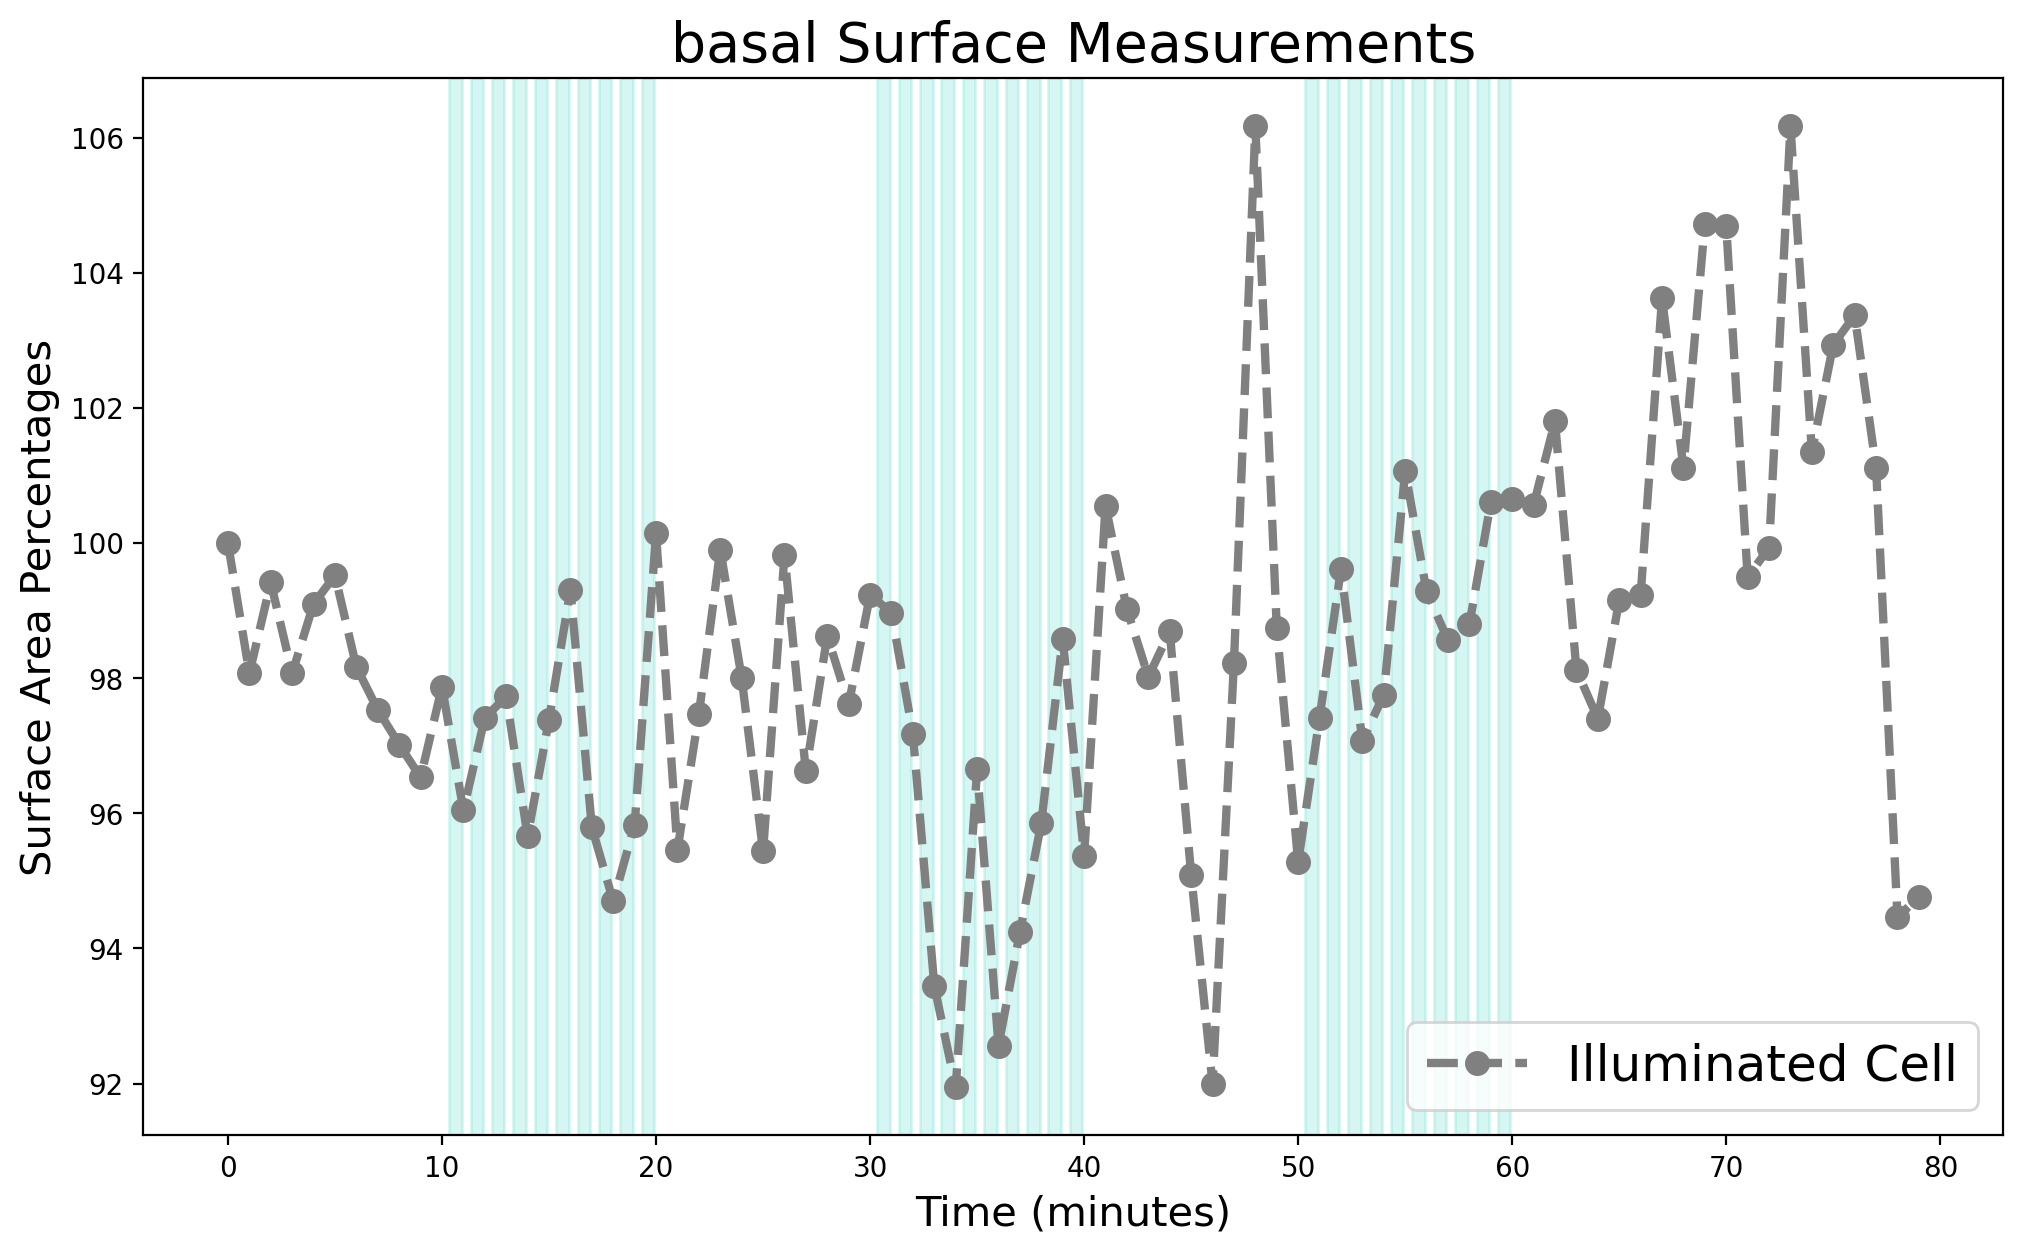

In [280]:
# To visualize the result we can make a graph to depict the apical surface area reduction
# Axis x will show area and axis y will show time 


# To display time we need to take into account the time difference between timepoints or the Cycle time we used while doing imaging
# We multiply by the time (use decimal) to correct
timecorrection = 1 #1 timepoint is 1 minute
finalarea = np.copy(temporal3) # we make a copy of the array we made before to avoid mistakes
finalarea[:,0] = finalarea[:,0] * timecorrection
print(finalarea)

# Then we want to normalize using the first area measurement so that the reduction is shown as a percentage of the original surface area of the cell
# We make a list with the areas to divide with the original one
print(temporal3[:,1])
areastodiv = temporal3[:,1]
areastodiv
areasdivlist = areastodiv.tolist()
areasdivlist

# Here we divide each measurement to the first
# i / originalsurfacearea * 100 
# the originalsurfacearea is the surface measurement for the first timepoint and we multiply by 100 to make it a percentage
# If the surface area measurement on the first timepoint was 10934 we would do: 

percentareas = []
for i in areasdivlist:
    percentareas.append(i / firstarea * 100)
print(percentareas)  # we print to check

#We create new directory for analyzed data 

#First, using this to automatically obtain date when data was analyzed
from datetime import date
today = date.today()
d1 = today.strftime("%Y_%m_%d") # This puts the date in format year, month day

Outname = d1 + "Analysis_" + aorb + originalname
filesaver = join(dirpath, Outname)
# Then we can plot using the correct timepoints (with the correct minutes according to our imaging cycle) and with the reduction of surface area percentage 
# We can change the label according to which cell we are studying
plt.figure(figsize = (12, 7), dpi=200)
for i in range(10, 20):
    plt.axvspan(i + 0.333, i + 0.917, color = '#78e3d8', alpha = 0.3)
for i in range(30, 40):
    plt.axvspan(i + 0.333, i + 0.917, color = '#78e3d8', alpha = 0.3)
for i in range(50, 60):
    plt.axvspan(i + 0.333, i + 0.917, color = '#78e3d8', alpha = 0.3)
plt.plot(finalarea[:,0], percentareas, 'go--', linewidth = 3, markersize = 8, color = 'gray', label = 'Illuminated Cell' )
plt.title(aorb +' Surface Measurements', fontsize = 20)
plt.xlabel('Time (minutes)', fontsize = 15)
plt.ylabel('Surface Area Percentages', fontsize = 15)
plt.legend(fontsize = '18')
plt.savefig(filesaver +'_ConstrictionGraphbasal.png',  bbox_inches='tight')
#plt.show()

In [281]:
###Update on the 19th June 2020
#Save to output folder: 
DataOutputFolder = r"C:\Users\ara\Documents\Python Scripts\Repeated Stimulation Analysis\Analyzed Data"
DataOutput = originalname + "_analyzed_"+ aorb + d1 + ".csv"
DataOut = join(DataOutputFolder, DataOutput)
# We save the numpy array of surface area measurements for each timepoint 
np.savetxt(DataOut, finalarea, delimiter=',', fmt = '%d')
print("Data has been saved to" + DataOut)

Data has been saved toC:\Users\ara\Documents\Python Scripts\Repeated Stimulation Analysis\Analyzed Data\20201211 Optoshroom repeated stim 3 att3_analyzed_basal2020_12_15.csv


In [282]:
###Update on the 11th June 2020. I want to add saving the segmented image as Tif and a gif of the segmented vs. unsegmented. 
#This package is not normally included in anaconda etc, so it has to be installed in the command line. 
# We would use python -m pip install tifffile
#Now we can import it
import tifffile


In [283]:
#We have al watershed planes in listofplanes. But we need to have them all in a numpy array and dimensions in correct order

#Let's try same shape as proj.
proj.shape

WatershedAll = np.zeros_like(proj)
for i in range(time):
    WatershedAll[i,:,:] =listofplanes[i] 
#Now it's all in a 3D np.array, not in a list of np.arrays

In [284]:
#Now we can save them!
WatershedAll = np.expand_dims(WatershedAll, axis = 1) #we add the empty dimensions for Image J to read it as time!
tifffile.imwrite(filesaver + "_WatershedImage.tif", WatershedAll, imagej = True)
#Recomendation, use LUT 16 colors on image J to watch

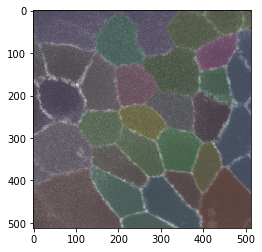

[range(1, 10)]
